In [1]:
import seaborn as sns
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,BatchNormalization
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
DATA_DIR = 'data'
IMAGE_DIR = f'../{DATA_DIR}/dataset'

image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
    )

data_train = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'   
)

data_val = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'   
)

N_CLASSES = data_train.num_classes

Found 4146 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [3]:

IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [4]:
def finetuned_inceptionresnet(include_top=False):
    base_model = InceptionResNetV2(include_top=include_top,input_shape=IMSIZE,weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    if not include_top:
        x = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [5]:
inception_model = finetuned_inceptionresnet()


2022-07-09 03:17:15.661156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 03:17:15.665755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 03:17:15.665955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 03:17:15.666913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

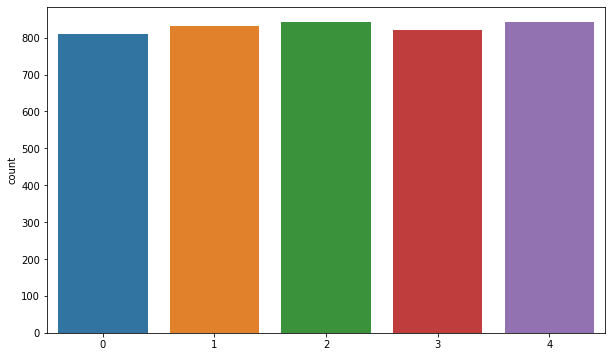

In [6]:
y = data_train.labels

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [7]:
inception_model.optimizer.learning_rate = 0.0001
inception_model.optimizer.momentum = 0.9
with tf.device('/gpu:0'):
    history = inception_model.fit_generator(data_train,validation_data=data_val, epochs=100)


/tmp/ipykernel_129580/2425520805.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = inception_model.fit_generator(data_train,validation_data=data_val, epochs=100)


Epoch 1/100


2022-07-09 03:17:30.804701: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-09 03:17:31.213310: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


17/17 [==============================] - 34s 1s/step - loss: 0.4989 - accuracy: 0.8437 - val_loss: 0.2374 - val_accuracy: 0.9265
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 0.1851 - accuracy: 0.9385 - val_loss: 0.1883 - val_accuracy: 0.9362
Epoch 3/100
17/17 [==============================] - 18s 1s/step - loss: 0.1389 - accuracy: 0.9520 - val_loss: 0.1567 - val_accuracy: 0.9507
Epoch 4/100
17/17 [==============================] - 17s 1s/step - loss: 0.1250 - accuracy: 0.9588 - val_loss: 0.1421 - val_accuracy: 0.9565
Epoch 5/100
17/17 [==============================] - 17s 1s/step - loss: 0.1122 - accuracy: 0.9650 - val_loss: 0.1436 - val_accuracy: 0.9603
Epoch 6/100
17/17 [==============================] - 17s 1s/step - loss: 0.0866 - accuracy: 0.9703 - val_loss: 0.1362 - val_accuracy: 0.9594
Epoch 7/100
17/17 [==============================] - 17s 1s/step - loss: 0.0955 - accuracy: 0.9691 - val_loss: 0.0867 - val_accuracy: 0.9720
Epoch 8/100
17/17 [======

In [8]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

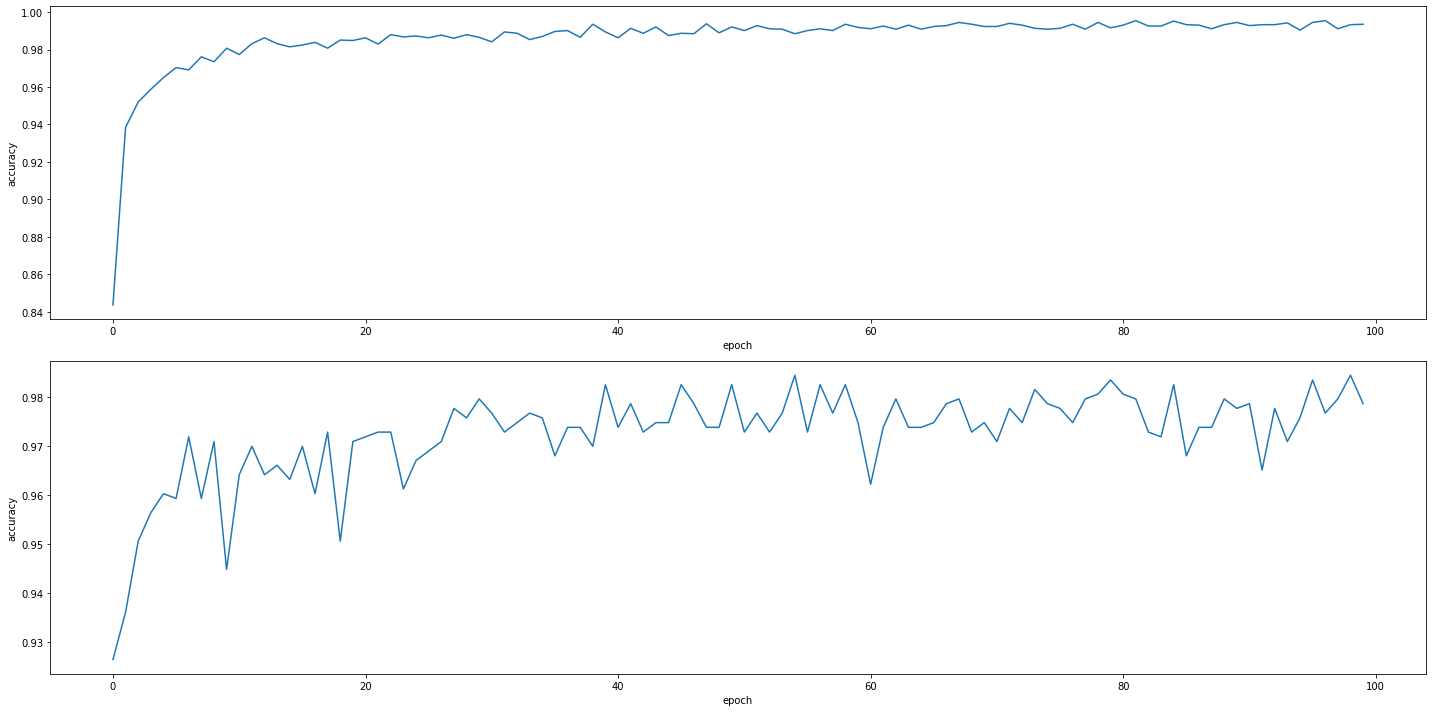

In [9]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


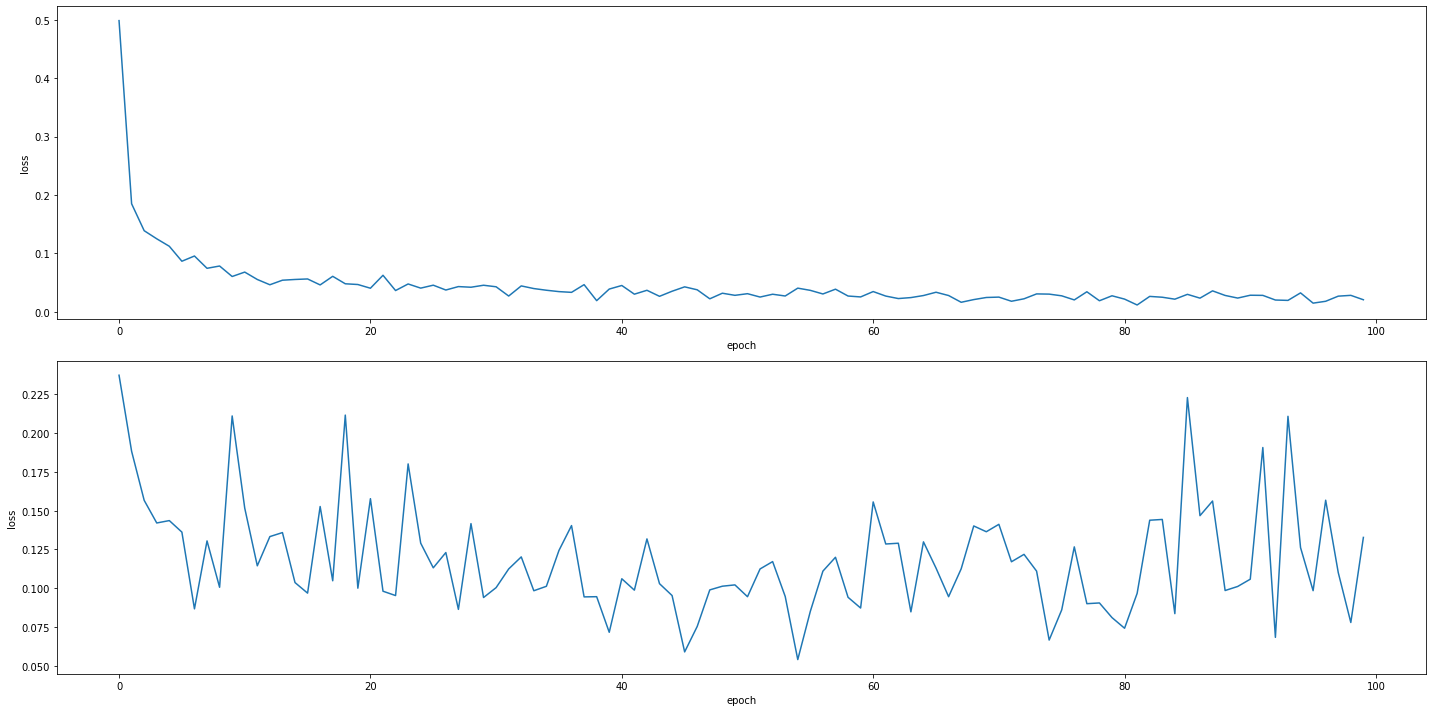

In [10]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [11]:
inception_model.save('../model/saved/inception_model.h5')